# Validation

This notebook will compare the outputs of measurements done with napari-stress to those of the legacy-version [STRESS](https://github.com/campaslab/STRESS). The analysis usually comprises two steps - reconstruction of the droplet and the stress measurement - we treat these separately in this respect.

We compare three analysis workflows:

* Using the reconstruction and the measurement from STRESS
* Using the napari-stress reconstruction and the measurement from STRESS
* using the napari-stress reconstruction and the measurement from napari-stress

We compare the reconstruction and measured quantities for the following **synthetic data**:

* Ideal sphere

## Comparisons:

For all workflows, we compare the following quantities:

* The reconstructed pointcloud: Since the reconstructed object should be perfectly spherical, we can convert the reconstructed pointcloud coordinates to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) and compare the distribution of radii of both reconstructions. 
* Measured mean curvatures: Similar to the distribution of measured radii, the measured mean curvatures should follow a similar and ideally narrow distributioin
* Total [stress anisotropies](https://www.biorxiv.org/content/10.1101/2021.03.26.437148v1.full): For an ideal sphere, these should be as close to zero as possible.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import napari
import pandas as pd
import vedo
import seaborn as sns

In [2]:
viewer = napari.Viewer()

15-Feb-23 13:37:13 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 2172x1352+1606+644 (frame: 2198x1423+1593+586) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 4350x2119+1611+671 (frame: 4376x2190+1598+613) margins: 13, 58, 13, 13 minimum size: 374x560 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=774,1191 maxtrack=0,0)


In [3]:
dataset = os.path.join('.')

In [4]:
pointcloud_stress0 = pd.read_csv(os.path.join(dataset, 'stress_analysis_and_stress_pointcloud', 'pointcloud.csv'), sep=',', header=None).to_numpy()
pointcloud_napari_stress0 = pd.read_csv(os.path.join(dataset, 'napari_stress_analysis_and_napari_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()

When we look at the pointclouds, we see a clear offset, which likely originates from different axis conventions in napari (ZYX) and Matlab (YXZ)

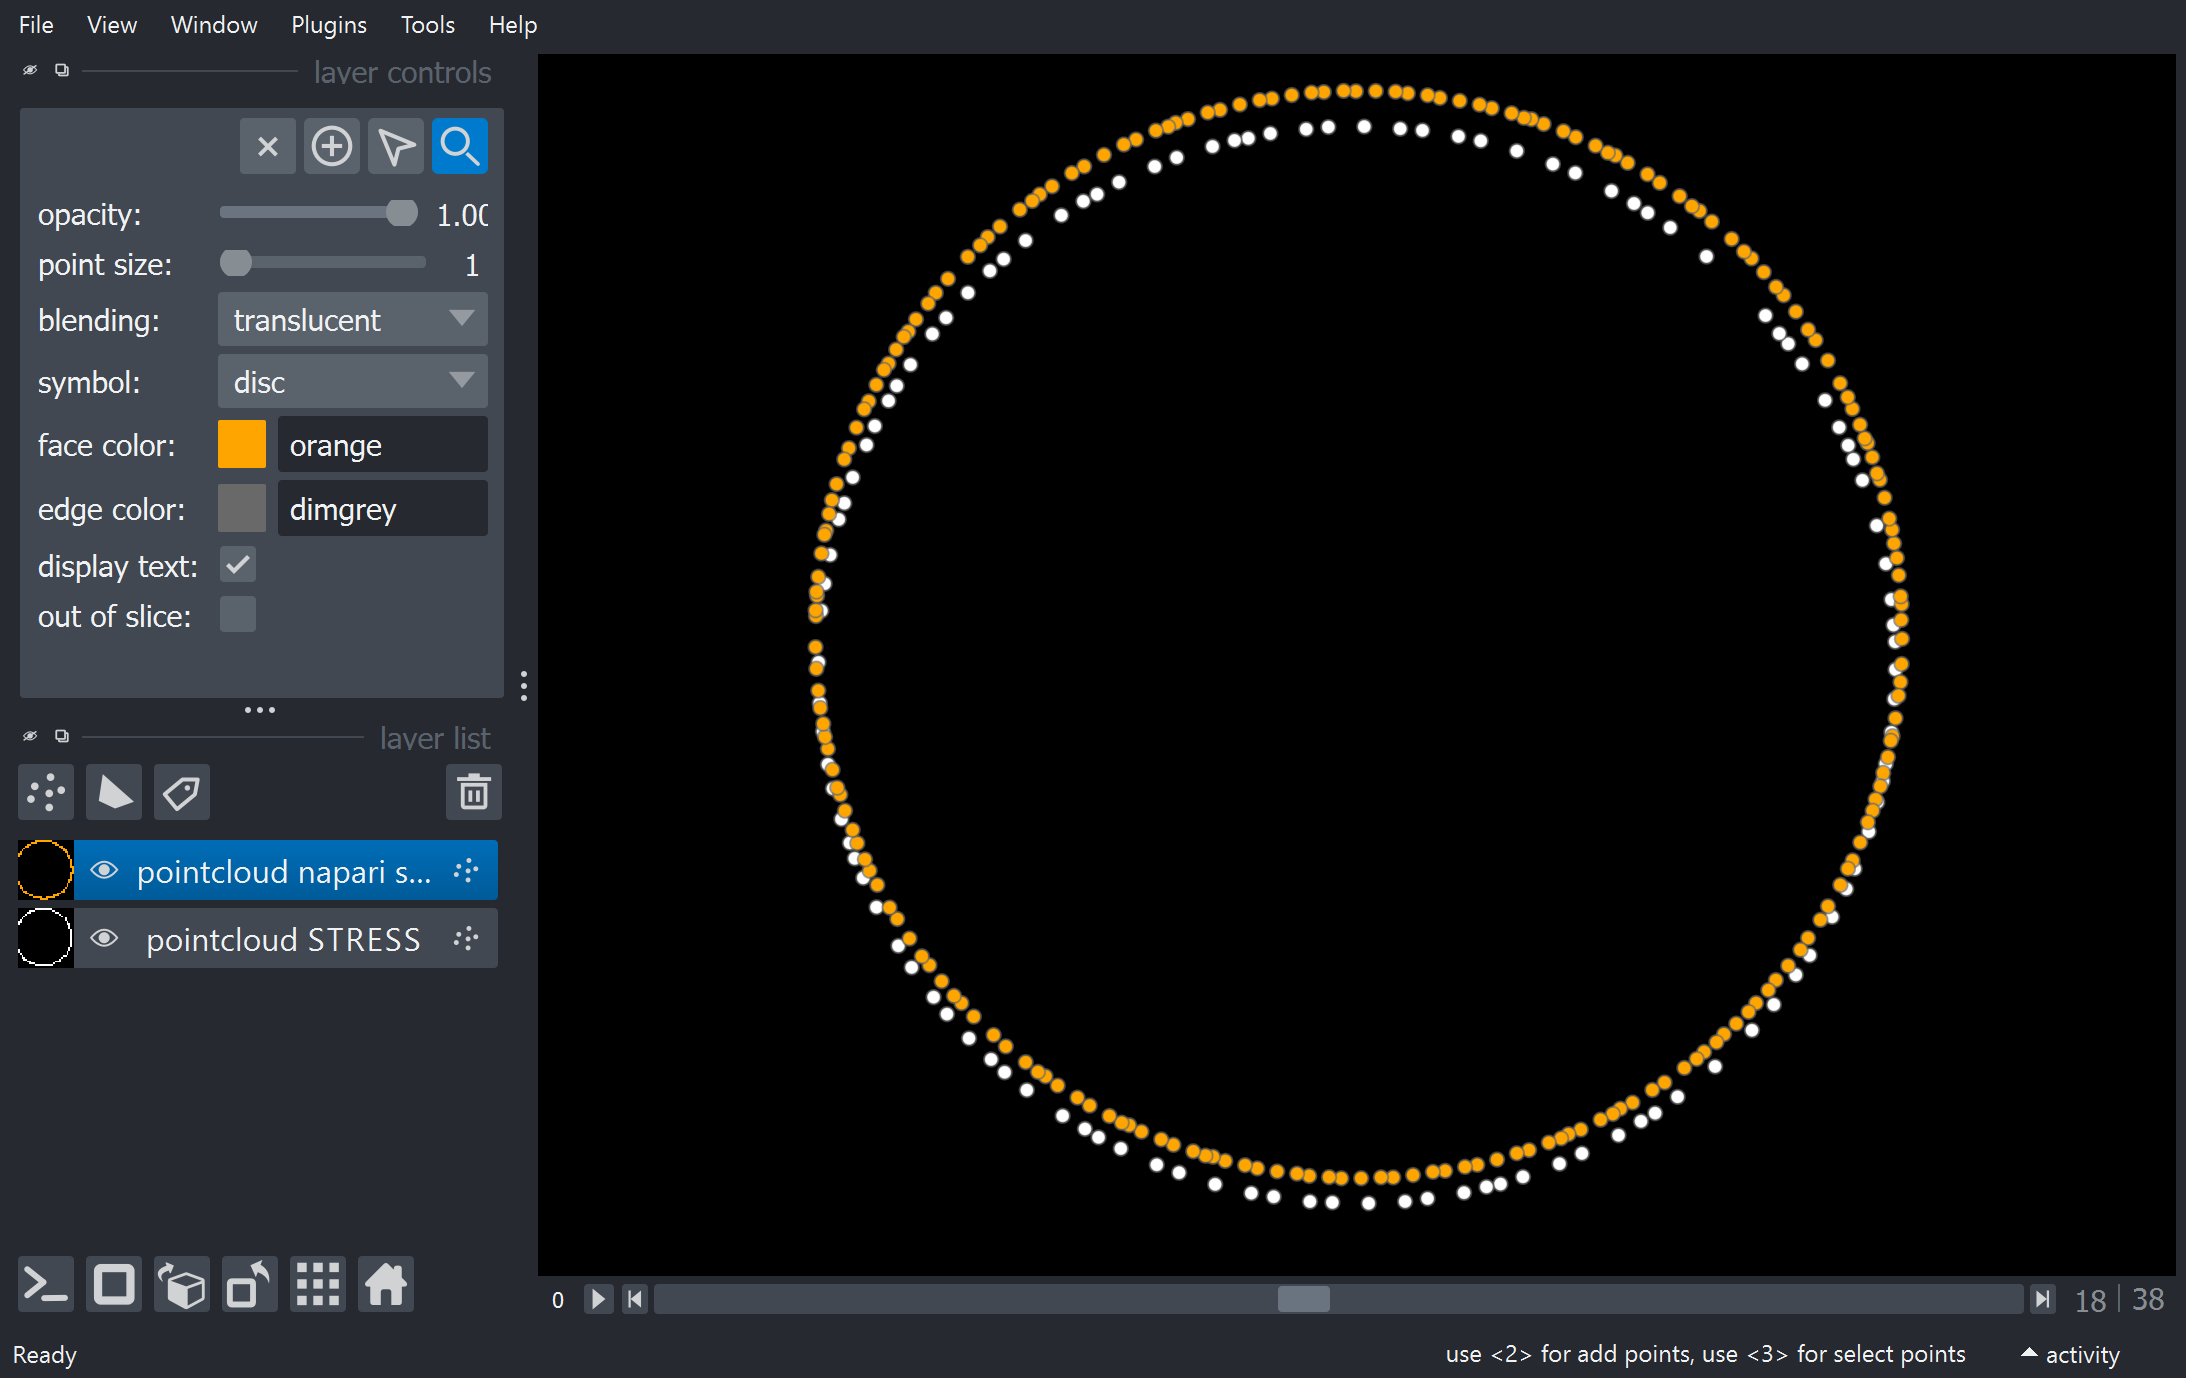

In [5]:
viewer.add_points(pointcloud_stress0, size=0.5, name='pointcloud STRESS')
viewer.add_points(pointcloud_napari_stress0, size=0.5, face_color='orange', name='pointcloud napari stress')
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Radii

We can measure the offsets of the two pointclouds:

In [6]:
offset = pointcloud_stress0.mean(axis=0) - pointcloud_napari_stress0.mean(axis=0)
offset

array([ 0.81884031,  0.99143161, -0.19145904])

To compare the two pointcouds, we can convert both to relative coordinates by subtracting the pointcloud's center from every point:

In [7]:
pointcloud_stress0_centered = pointcloud_stress0 - pointcloud_stress0.mean(axis=0)[None, :]
pointcloud_napari_stress0_centered = pointcloud_napari_stress0 - pointcloud_napari_stress0.mean(axis=0)[None, :]

We can convert the points into spherical coordinates and measure the distribution of radii:

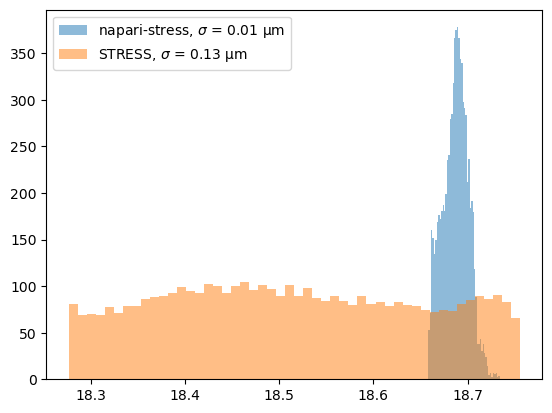

In [10]:
r_ns, phi_ns, theta_ns = vedo.cart2spher(pointcloud_napari_stress0_centered[:, 0], pointcloud_napari_stress0_centered[:, 1], pointcloud_napari_stress0_centered[:, 2])
r_s, phi_s, theta_s = vedo.cart2spher(pointcloud_stress0_centered[:, 0], pointcloud_stress0_centered[:, 1], pointcloud_stress0_centered[:, 2])

mpl.style.use('default')
fig, ax = plt.subplots()
ax.hist(r_ns, 50, label='napari-stress, $\sigma$ = {:.2f} µm'.format(r_ns.std()), alpha=0.5)
ax.hist(r_s, 50, label='STRESS, $\sigma$ = {:.2f} µm'.format(r_s.std()), alpha=0.5)
ax.legend()

In [13]:
for layer in viewer.layers:
    layer.visible = False
viewer.add_points(pointcloud_napari_stress0_centered, properties={'radius': r_ns}, face_color='radius', size=1)
viewer.add_points(pointcloud_stress0_centered, properties={'radius': r_s}, face_color='radius', size=1)

<Points layer 'pointcloud_stress0_centered [1]' at 0x13d6172d790>

For napari-stress, you see some small variations across the surface

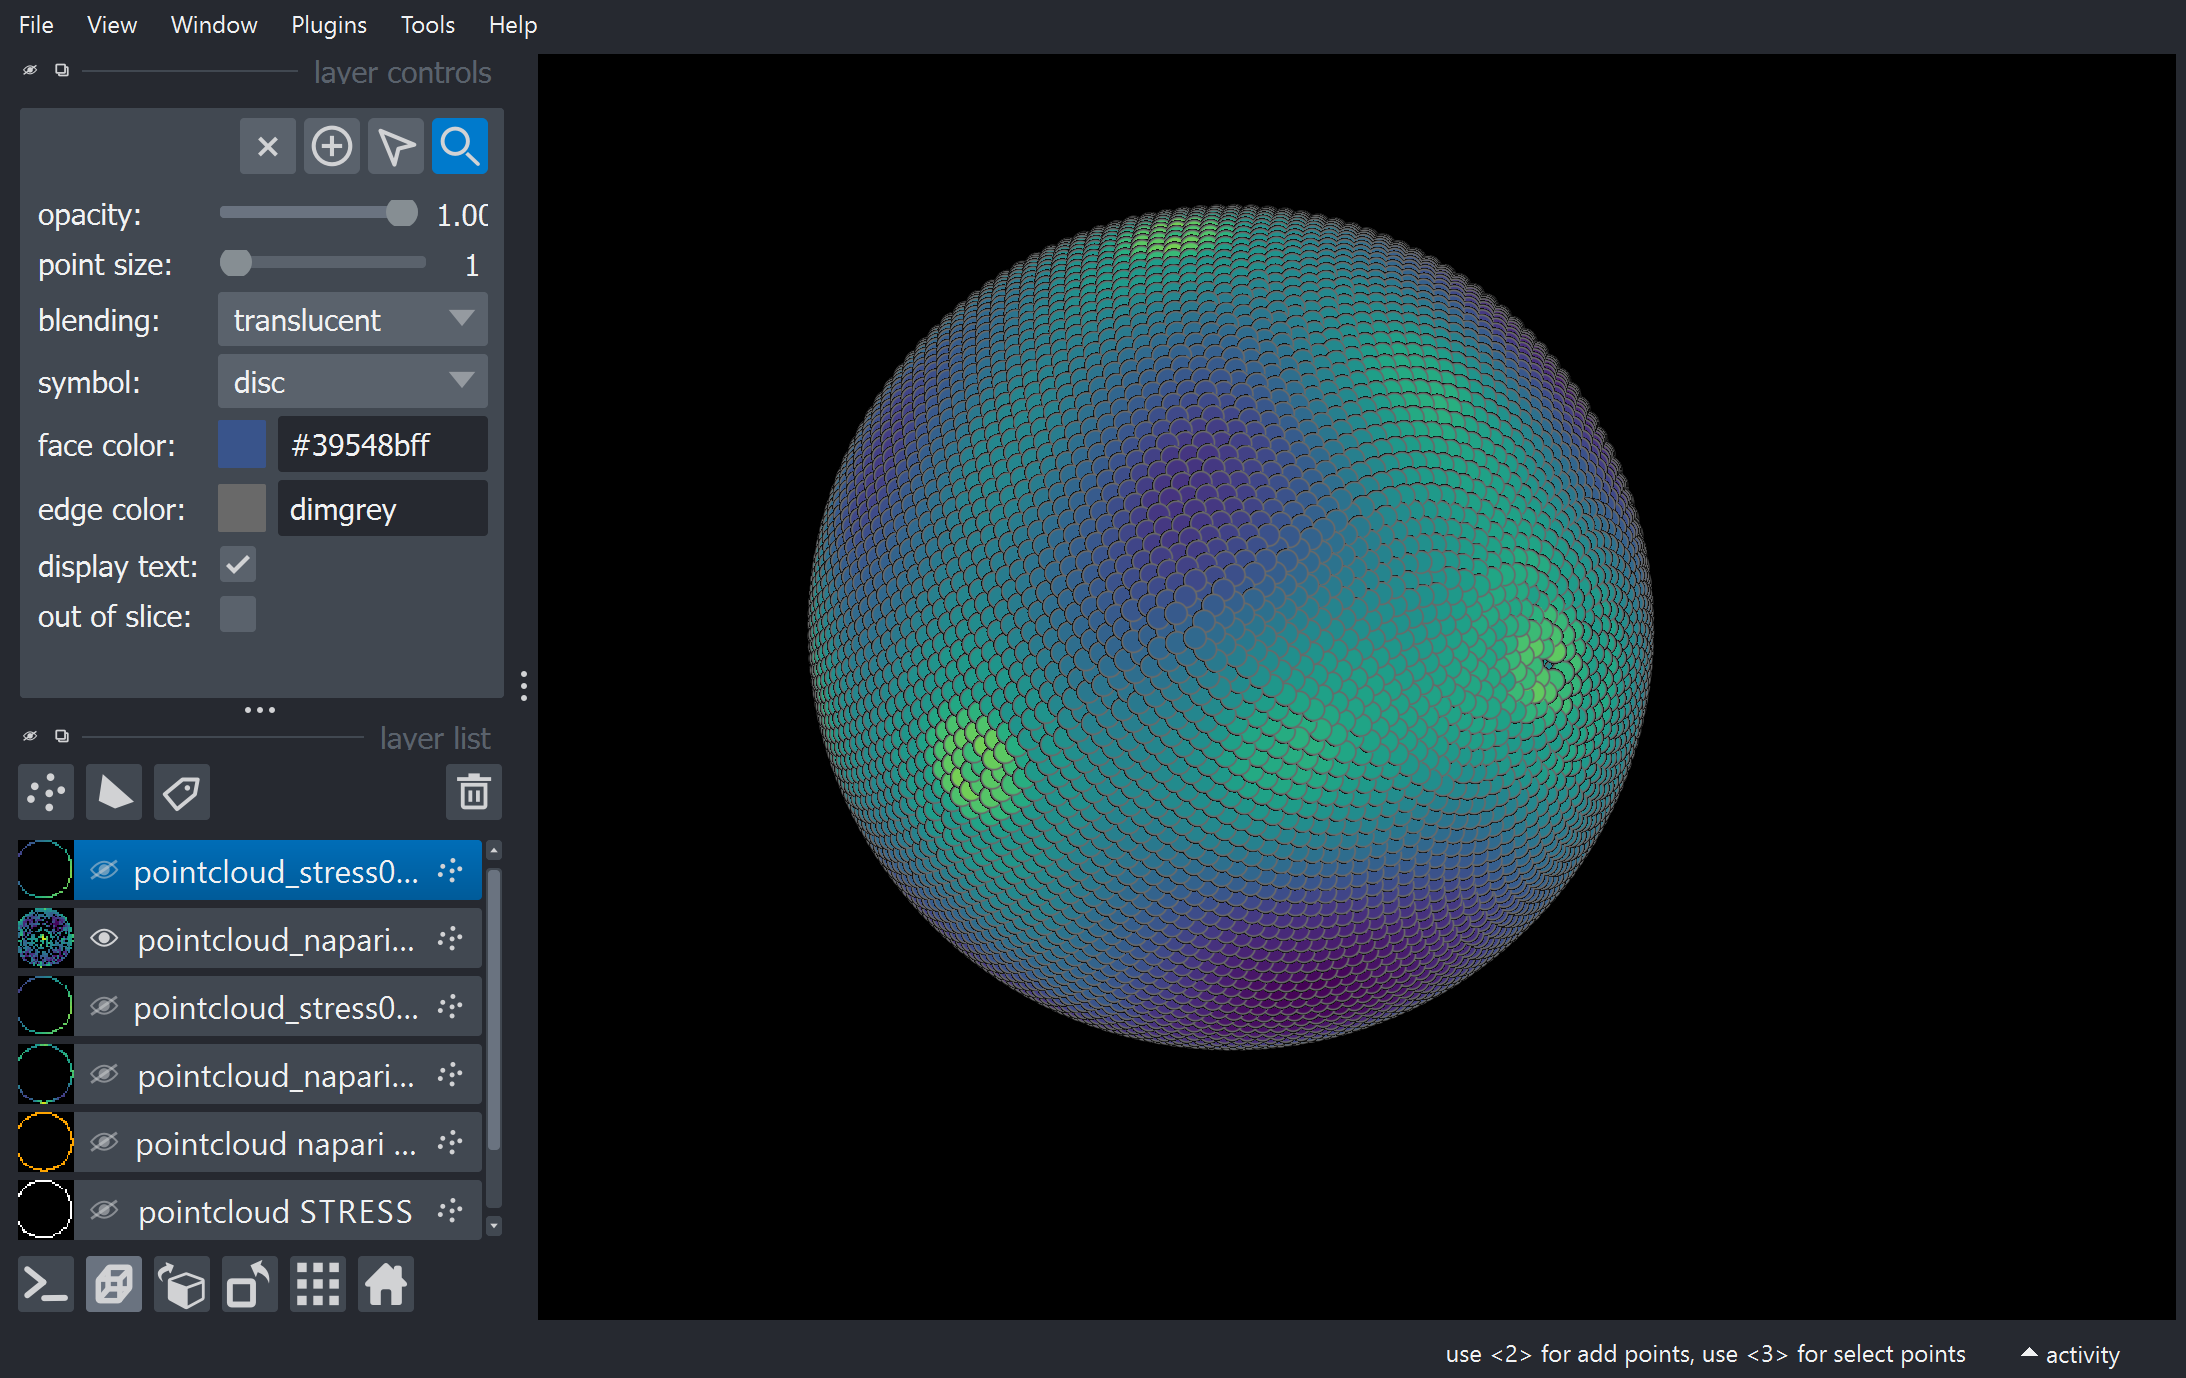

In [17]:
napari.utils.nbscreenshot(viewer, canvas_only=False)

For STRESS, you see a systematic deviation from north- to southpole:

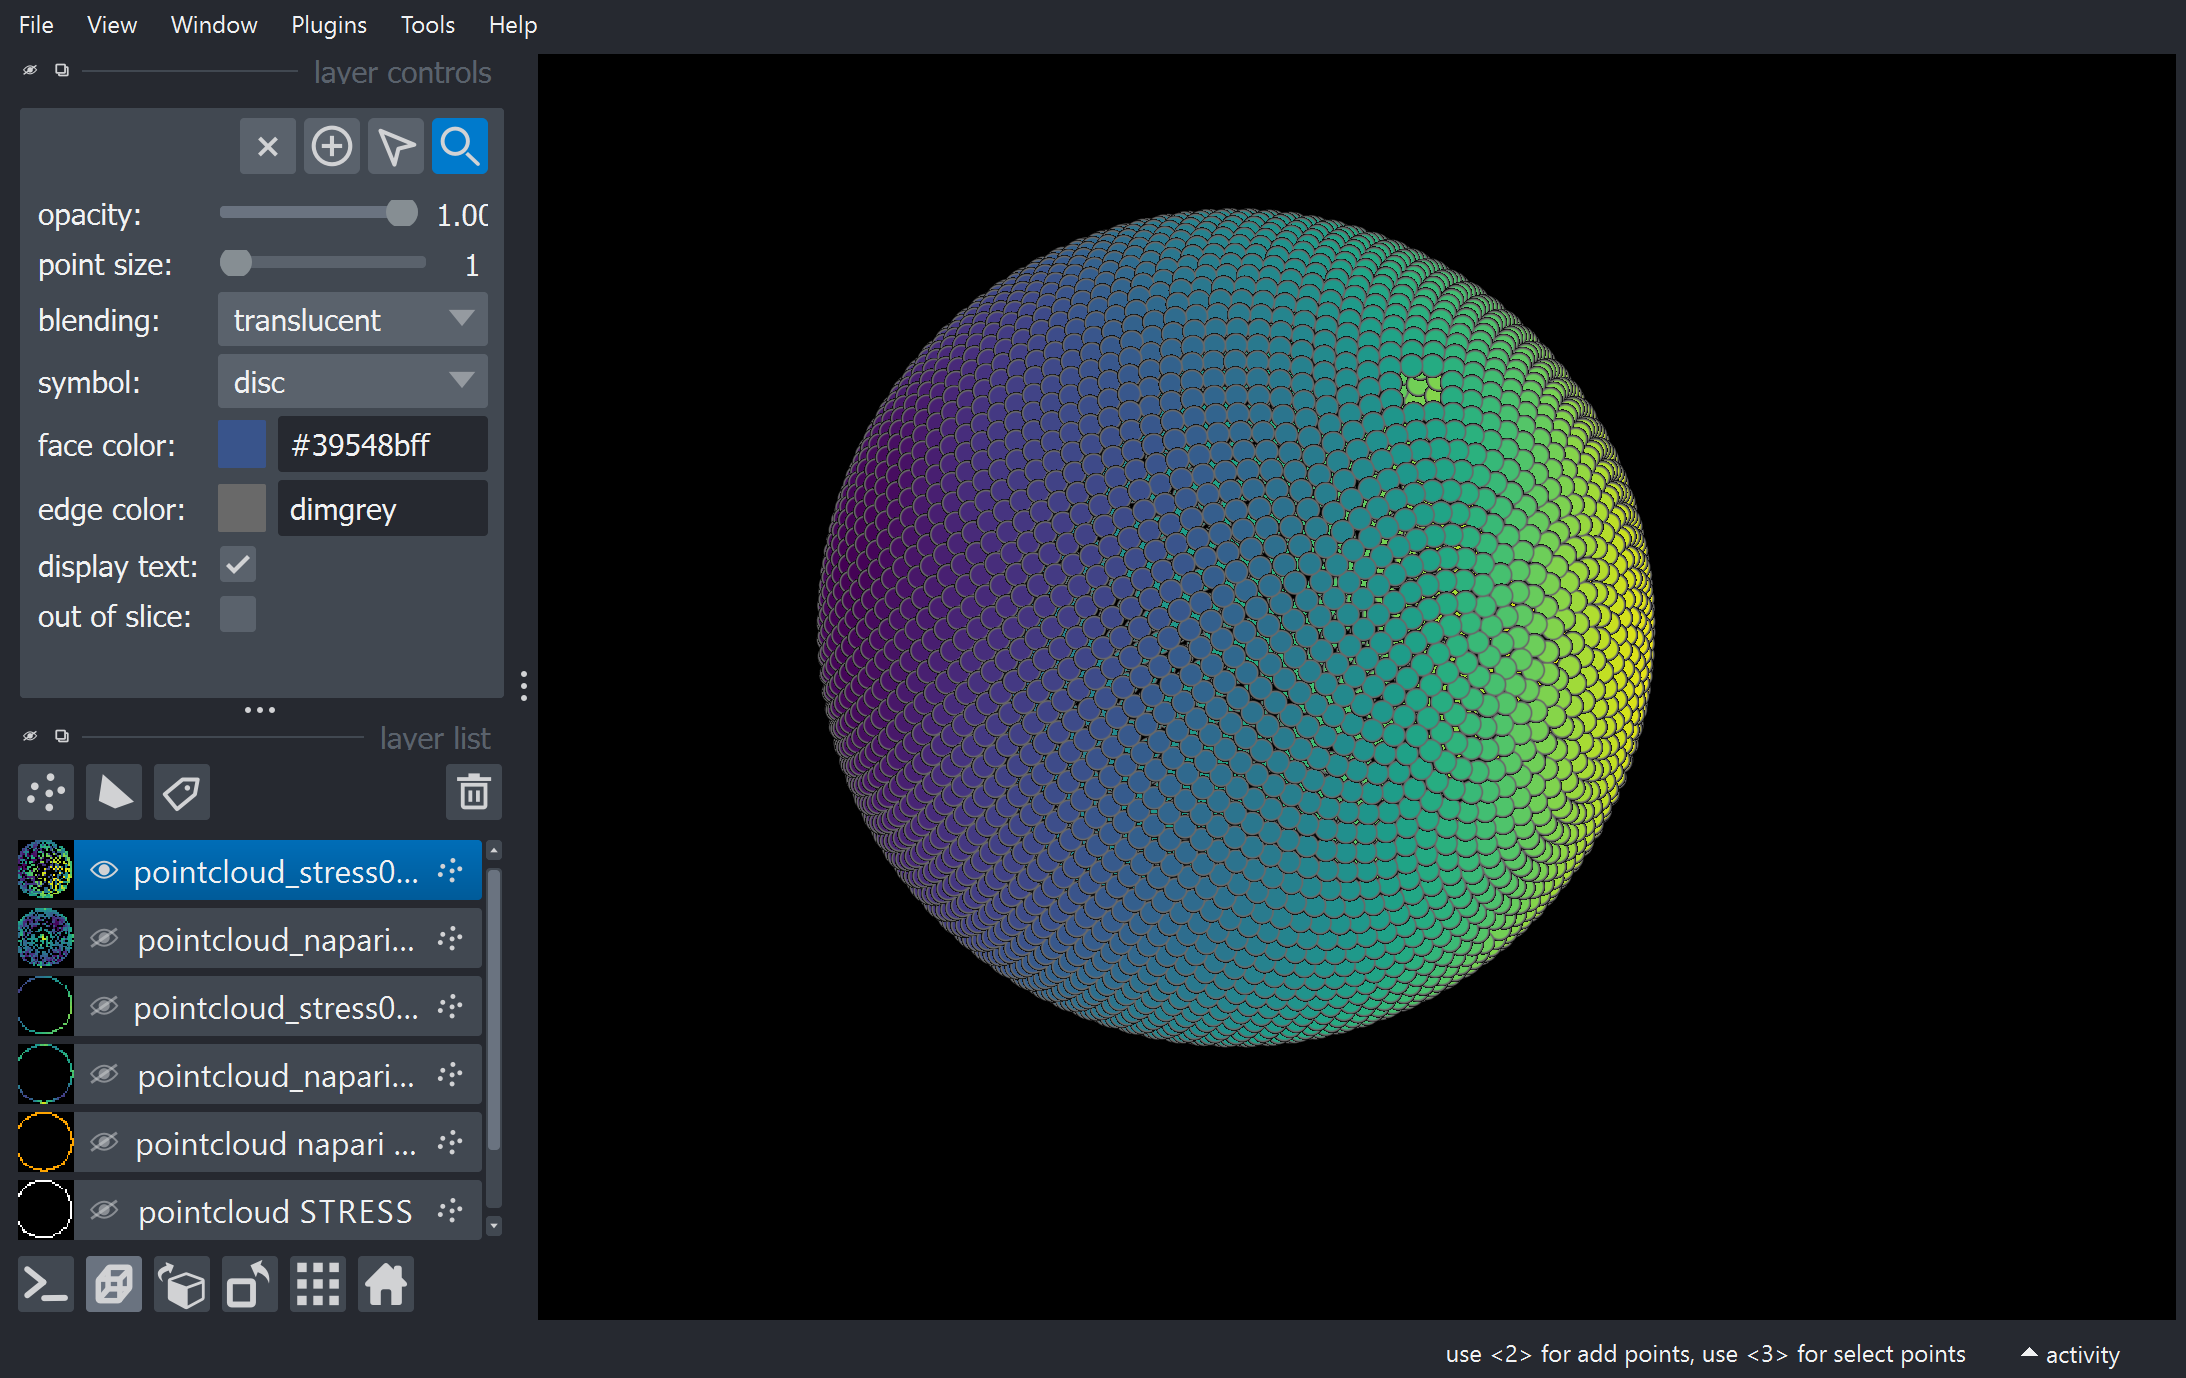

In [18]:
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Mean curvatures

Here, we compare the measured mean curvatures for each of the above-described workflows:

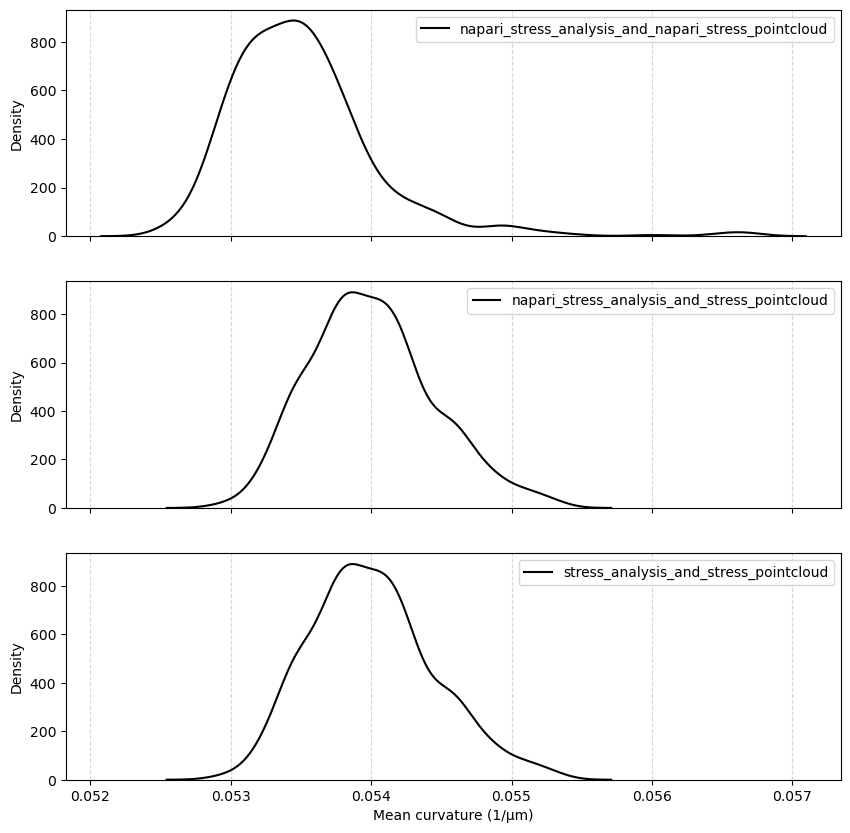

In [19]:
mpl.style.use('default')

fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
file = 'mean_curvatures.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    mean_curvatures = np.loadtxt(os.path.join(dataset, directory, 'mean_curvatures.csv'))
    sns.kdeplot(data=mean_curvatures, ax=axes[idx], label=directory, color='k')
    axes[idx].set_xlabel('Mean curvature (1/µm)')
    axes[idx].grid(which='major', axis='x', linestyle='--', alpha=0.5)

    axes[idx].legend()
    idx += 1


## Compare stresses

Here we compare total/cell/tissue stresses for the three workflows:

In [20]:
def calculate_anisotropy(values, alpha=0.05):
    from scipy import stats
    hist_data = np.histogram(values, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)

    return largest_excluded_value - smallest_excluded_value

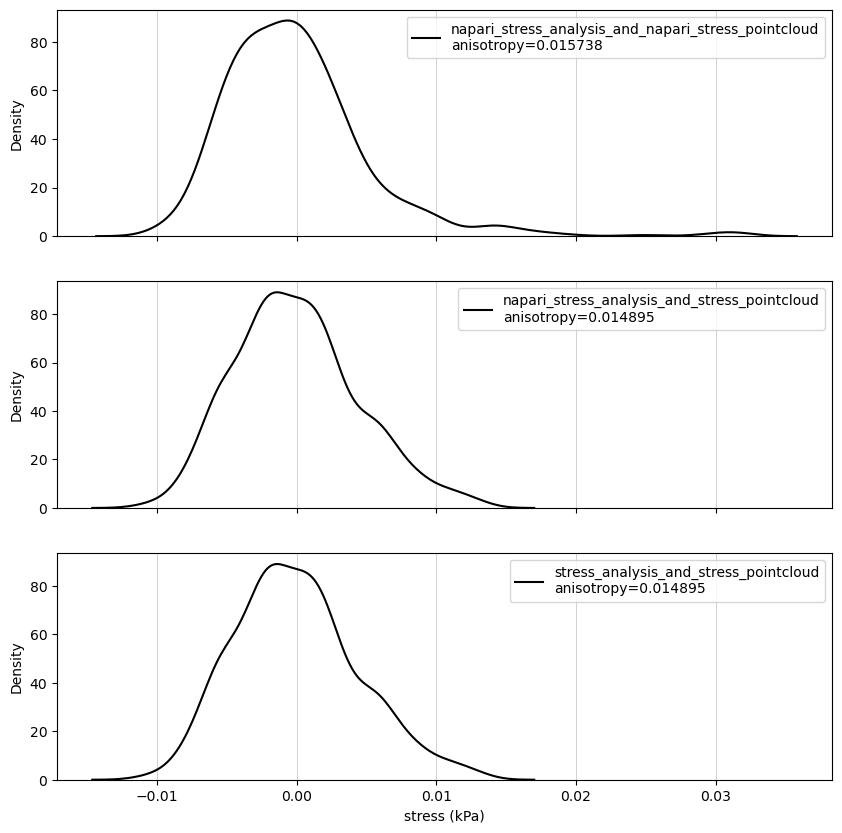

In [21]:
fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
file = 'total_stress.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    total_stresses = np.loadtxt(os.path.join(dataset, directory, file))
    anisotropy = calculate_anisotropy(total_stresses)
    sns.kdeplot(data=total_stresses, ax=axes[idx], label=directory+'\nanisotropy={:2f}'.format(anisotropy), color='k')
    axes[idx].set_xlabel('stress (kPa)')
    axes[idx].grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)

    axes[idx].legend()
    idx += 1
